In [2]:
from IPython.display import Audio as Audio

#necessary libraries
import librosa
import os
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt

## Preliminary for feature extraction

In [2]:
#import tracks csv file for track_id and genre_top
tracks=pd.read_csv("./fma_metadata/tracks.csv", low_memory=False)

In [3]:
#all track ids start from index 2
id=tracks['Unnamed: 0'][2:]
id.head()

2     2
3     3
4     5
5    10
6    20
Name: Unnamed: 0, dtype: object

In [4]:
#labels for tracks start from index 2
genre=tracks['track.7'][2:]
genre.head()

2    Hip-Hop
3    Hip-Hop
4    Hip-Hop
5        Pop
6        NaN
Name: track.7, dtype: object

In [5]:
#change the track_id name to match fma_small filenames
count=2
for i in id:
    if len(i)==1:
        id[count]='00000'+i+'.mp3'
        count+=1
    elif len(i)==2:
        id[count]='0000'+i+'.mp3'
        count+=1
    elif len(i)==3:
        id[count]='000'+i+'.mp3'
        count+=1
    elif len(i)==4:
        id[count]='00'+i+'.mp3'
        count+=1
    elif len(i)==5:
        id[count]='0'+i+'.mp3'
        count+=1
#check if it worked
id.head()

2    000002.mp3
3    000003.mp3
4    000005.mp3
5    000010.mp3
6    000020.mp3
Name: Unnamed: 0, dtype: object

In [2]:
#describe genres by label number
dict_characters={0: 'Hip-Hop',1: 'Pop',2: 'Folk',3: 'Rock',4: 'Experimental',5: 'International',6: 'Instrumental',7: 'Electronic'}

In [9]:
# Audio preprocessing function
def compute_melgram(audio_path):
    ''' Compute a mel-spectrogram and returns it in a shape of (1,1,96,1366), where
    96 == #mel-bins and 1366 == #time frame
    parameters
    ----------
    audio_path: path for the audio file.
                Any format supported by audioread will work.
    More info: http://librosa.github.io/librosa/generated/librosa.core.load.html#librosa.core.load
    '''

    # mel-spectrogram parameters
    SR = 12000
    N_FFT = 512
    N_MELS = 96
    HOP_LEN = 256
    DURA = 29.12  # to make it 1366 frame..

    src, sr = librosa.load(audio_path, sr=SR)  # whole signal
    n_sample = src.shape[0]
    n_sample_fit = int(DURA*SR)

    if n_sample < n_sample_fit:  # if too short
        src = np.hstack((src, np.zeros((int(DURA*SR) - n_sample,))))
    elif n_sample > n_sample_fit:  # if too long
        src = src[int((n_sample-n_sample_fit)/2):int((n_sample+n_sample_fit)/2)]
    logam = librosa.amplitude_to_db
    melgram = librosa.feature.melspectrogram
    ret = logam(melgram(y=src, sr=SR, hop_length=HOP_LEN,
                        n_fft=N_FFT, n_mels=N_MELS)**2,
                ref=1.0)
    ret = ret[np.newaxis, :]
    return ret

In [10]:
#practice with melgram function
a=compute_melgram("./fma_small/000/000005.mp3")

In [11]:
#we have 4D!
a.shape

(1, 96, 1366)

In [356]:
#load audio files and extract features
mels=[] #will hold feature data
labs=[] #will hold label data
path=os.path.abspath(os.path.join("./fma_small/"))
for subfolder in os.listdir(path):
    for filename in os.listdir(os.path.join(path,subfolder)):
        try:
            #song, samp_rate=librosa.load(os.path.join(path,subfolder,filename), sr=None, res_type='kaiser_best')
            #extract mfcc feature from data
            #compute_melgram program automatically creates a 4D space 
            melgram=compute_melgram(os.path.join(path,subfolder,filename))
            mels.append(melgram)
            label=genre.loc[id == filename].values.tolist()
            if not label:
                label=genre.loc[id == filename[:6]].values.tolist()
            for key in dict_characters:
                if label[0] == dict_characters[key]:
                    labs.append(key)
                    break
                elif not label:
                    labs.append(8)
                    break
            #print('Success! Filename=%s with genre=%s' % (filename, label[0]))
        except Exception as e:
            filename='.ipynb_checkpoints'

In [360]:
len(mels)

7997

### Start slicing and reshaping

In [425]:
#save list as numpy array
mels=np.array(mels)

In [426]:
#check the shape for 4D
print(mels.shape)

(7997, 1, 1, 96, 1366)


In [428]:
len(labs)

7997

In [440]:
mels=list(mels)

In [441]:
#create the dataframe
df=pd.DataFrame()
df['songs']=mels
df['labels']=labs

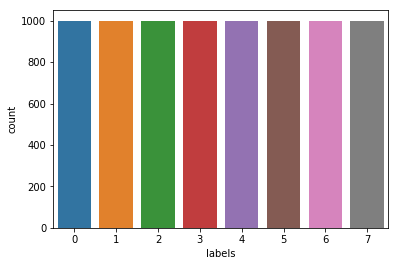

In [442]:
lab=df['labels']
dist=lab.value_counts()

#view the distribution of genres
import seaborn as sns
sns.countplot(lab)

In [443]:
#put x back to list
#*****REMEMBER: CONVERTING DATAFRAME TO NUMPY ARRAY FLATTENS THE DIMENSION TO 1, SO HAVE TO CONVERT BACK TO LIST FIRST*****#
mels=list(df['songs'])

In [444]:
#check dimension of features after dropping labels=8
mels=np.array(mels)
print(mels.shape)

(7997, 1, 96, 1366)


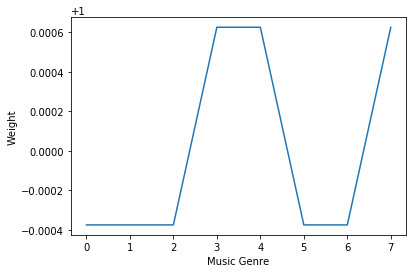

In [445]:
#balance the music genres 
from sklearn.utils import class_weight
class_weight4D=class_weight.compute_class_weight('balanced', np.unique(labs), labs)
plt.plot(class_weight4D)
plt.xlabel('Music Genre')
plt.ylabel('Weight')

#save class_weights
np.save('class_weight4D.npy', class_weight4D)

In [461]:
#view dimension of labels
print(lab.shape)

(7997,)


In [462]:
#create training and testing data
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(mels,labs,test_size=0.5)

#check the dimensions
print(x_train.shape)
print(x_test.shape)

(3998, 1, 96, 1366)
(3999, 1, 96, 1366)


In [463]:
#dummy code labels using one hot encoding
from keras.utils.np_utils import to_categorical

y_trainHot=to_categorical(y_train,num_classes=8)
y_testHot=to_categorical(y_test,num_classes=8)

/home/cc/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [1]:
#load the variables
x_train=np.load('x_train4DHalf.npy')
x_test=np.load('x_test4DHalf.npy')
y_trainHot=np.load('y_trainHot4DHalf.npy')
y_testHot=np.load('y_testHot4DHalf.npy')

NameError: name 'np' is not defined

In [19]:
#load the class weights
class_weight4D=np.load('class_weight4D.npy')

In [4]:
# Helper Functions, Learning Curves, and Confusion Matrix
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pylab as plt

#save all previous epochs for use in plotting Keras Learning Curve
#this is used in function below called plotKerasLearningCurve
class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

#Keras Learning Curve function
def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')
    
#Confuson Matrix function
import itertools
def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

/home/cc/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
#deep learning libraries
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation,Flatten,Conv2D,MaxPool2D,BatchNormalization
from keras.optimizers import Adam
import sklearn
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

In [6]:
x_train=x_train.T
x_test=x_test.T
print(x_train.shape)
print(x_test.shape)

(1366, 96, 1, 3998)
(1366, 96, 1, 3999)


In [7]:
x_train=np.moveaxis(x_train, 3, 0)

In [8]:
x_test=np.moveaxis(x_test, 3, 0)

In [9]:
x_train.shape

(3998, 1366, 96, 1)

In [10]:
x_test.shape

(3999, 1366, 96, 1)

In [22]:
#****EDIT THIS FOR TRYING DIFFERENT MODELS****#

#deep learning model
#a = x_train
#b = y_trainHot
#c = x_test
#d = y_testHot
#e = number of epochs
def runCNNmodel(a,b,c,d,e):
    batch=128
    num_labels=8
    one, two, three = x_train.shape[1], x_train.shape[2], x_train.shape[3]
    input_shape = (one, two, three)
    #intialize model
    model=Sequential()
    
    #visible layers
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu',input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    
    #8 output nodes
    model.add(Flatten())
    model.add(Dense(512, activation='relu')) #hidden layers
    model.add(Dropout(0.25))
    model.add(Dense(num_labels, activation='softmax'))
    
    #compile the model
    model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

    #train the model
    model.fit(a,b,batch_size=batch,epochs=e,validation_data=(c,d),callbacks=[MetricsCheckpoint('logs')], class_weight=class_weight4D)
    
    #compute predictions for confusion matrix
    Y_pred = model.predict(c)
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(Y_pred, axis=1),target_names=list(dict_characters.values())), sep='')
    Y_pred_classes = np.argmax(Y_pred,axis = 1)
    Y_true = np.argmax(d,axis = 1)
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
    
    #plot confusion matrix
    plot_confusion_matrix(cm=confusion_mtx,classes=list(dict_characters.values()))

In [ ]:
#run the model
runCNNmodel(x_train,y_trainHot,x_test,y_testHot,5)
#plot learning curves across epochs
plotKerasLearningCurve()

Train on 3998 samples, validate on 3999 samples
Epoch 1/5
3998/3998 [==============================] - 941s 235ms/step - loss: 13.1464 - acc: 0.1603 - val_loss: 13.1572 - val_acc: 0.1828
Epoch 2/5
1280/3998 [========>.....................] - ETA: 9:33 - loss: 13.9885 - acc: 0.1313